In [4]:
pip install requests beautifulsoup4 pandas

#Task 1: Data Collection and Web Scraping
Objective: Scrape book titles, prices, ratings, and availability from all pages of books.toscrape.com and save the data to a CSV file.

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# Base URL of the website
base_url = 'http://books.toscrape.com/catalogue/'
current_page_url = base_url + 'page-1.html'

# List to store data for all books
all_books_data = []

# A dictionary to convert star rating text to a number
rating_map = {
    'One': 1,
    'Two': 2,
    'Three': 3,
    'Four': 4,
    'Five': 5
}

print("Starting the scraping process...")

while True:
    try:
        # Send an HTTP GET request to the current page
        response = requests.get(current_page_url)
        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)

        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all book containers on the page
        books = soup.find_all('article', class_='product_pod')

        # If no books are found, we've likely gone past the last page
        if not books:
            break

        # Extract data for each book
        for book in books:
            title = book.h3.a['title']
            price_str = book.find('p', class_='price_color').text
            # Clean and convert price to float
            price = float(price_str.replace('£', ''))

            # Extract star rating
            rating_class = book.find('p', class_='star-rating')['class'][1]
            rating = rating_map.get(rating_class, 0) # Default to 0 if not found

            availability = book.find('p', class_='instock availability').text.strip()

            all_books_data.append({
                'Title': title,
                'Price': price,
                'Rating': rating,
                'Availability': availability
            })

        # --- Handle Pagination ---
        # Find the 'next' button link
        next_button = soup.find('li', class_='next')
        if next_button:
            # Get the relative URL and construct the full URL for the next page
            next_page_relative_url = next_button.a['href']
            current_page_url = base_url + next_page_relative_url
            print(f"Navigating to next page: {current_page_url}")
            time.sleep(1) # Be a good citizen and add a small delay
        else:
            # No 'next' button found, so we are on the last page
            break

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        break

print("Scraping finished.")

# --- Store the data in a structured format ---
# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(all_books_data)

# Save the DataFrame to a CSV file
df.to_csv('books_data.csv', index=False)

print(f"Data for {len(df)} books has been successfully saved to books_data.csv")

Starting the scraping process...
Navigating to next page: http://books.toscrape.com/catalogue/page-2.html
Navigating to next page: http://books.toscrape.com/catalogue/page-3.html
Navigating to next page: http://books.toscrape.com/catalogue/page-4.html
Navigating to next page: http://books.toscrape.com/catalogue/page-5.html
Navigating to next page: http://books.toscrape.com/catalogue/page-6.html
Navigating to next page: http://books.toscrape.com/catalogue/page-7.html
Navigating to next page: http://books.toscrape.com/catalogue/page-8.html
Navigating to next page: http://books.toscrape.com/catalogue/page-9.html
Navigating to next page: http://books.toscrape.com/catalogue/page-10.html
Navigating to next page: http://books.toscrape.com/catalogue/page-11.html
Navigating to next page: http://books.toscrape.com/catalogue/page-12.html
Navigating to next page: http://books.toscrape.com/catalogue/page-13.html
Navigating to next page: http://books.toscrape.com/catalogue/page-14.html
Navigating to

#Task 2: Data Cleaning and Preprocessing
Objective: Clean the scraped books_data.csv to make it ready for analysis. We will handle hypothetical missing data, outliers, encode categorical data, and normalize numerical features.

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the raw data
try:
    df = pd.read_csv('books_data.csv')
    print("Original Data Info:")
    df.info()
    print("\nOriginal Data Head:")
    print(df.head())
except FileNotFoundError:
    print("Error: 'books_data.csv' not found. Please run the scraping task first.")
    exit()

# --- 1. Handle Missing Data ---
# Our scraper was robust, so the data is clean. Let's introduce some missing values for demonstration.
# Randomly insert 5 missing values in the 'Rating' column.
for _ in range(5):
    df.loc[np.random.randint(0, len(df)), 'Rating'] = np.nan

print("\nChecking for missing values:")
print(df.isnull().sum())

# Impute missing 'Rating' values with the median rating.
# Median is often better than mean for ordinal data or skewed distributions.
median_rating = df['Rating'].median()
df['Rating'].fillna(median_rating, inplace=True)
print("\nMissing values after imputation:")
print(df.isnull().sum())


# --- 2. Detect and Remove Outliers ---
# We'll use the Interquartile Range (IQR) method on the 'Price' column.
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]
print(f"\nFound {len(outliers)} outliers based on price.")

# Remove outliers
df_cleaned = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)].copy()
print(f"Dataset size after removing outliers: {len(df_cleaned)}")


# --- 3. Convert Categorical Variables ---
# The 'Availability' column is categorical. We can use Label Encoding as there seems to be a natural order
# (e.g., In stock > Available to order), or One-Hot Encoding if we assume no order.
# Let's use Label Encoding for simplicity.
label_encoder = LabelEncoder()
df_cleaned['Availability_Encoded'] = label_encoder.fit_transform(df_cleaned['Availability'])

# Display the mapping
print("\nLabel Encoding for 'Availability':")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"'{class_name}' -> {i}")


# --- 4. Normalize or Standardize Numerical Data ---
# We will standardize 'Price' and 'Rating' to have a mean of 0 and a standard deviation of 1.
# This is useful for many machine learning algorithms.
scaler = StandardScaler()
numerical_cols = ['Price', 'Rating']
df_cleaned[numerical_cols] = scaler.fit_transform(df_cleaned[numerical_cols])

print("\nData after cleaning and preprocessing (showing standardized columns):")
print(df_cleaned.head())

# Save the cleaned data to a new CSV file
df_cleaned.to_csv('books_cleaned_data.csv', index=False)
print("\nCleaned data saved to 'books_cleaned_data.csv'")

Original Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         1000 non-null   object 
 1   Price         1000 non-null   float64
 2   Rating        1000 non-null   int64  
 3   Availability  1000 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 31.4+ KB

Original Data Head:
                                   Title  Price  Rating Availability
0                   A Light in the Attic  51.77       3     In stock
1                     Tipping the Velvet  53.74       1     In stock
2                             Soumission  50.10       1     In stock
3                          Sharp Objects  47.82       4     In stock
4  Sapiens: A Brief History of Humankind  54.23       5     In stock

Checking for missing values:
Title           0
Price           0
Rating          5
Availability    0
dtype: int64

Mis

/tmp/ipython-input-1099914408.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Rating'].fillna(median_rating, inplace=True)


#Task 3: Exploratory Data Analysis (EDA)
Objective: Analyze the cleaned dataset to find patterns, compute statistics, and visualize relationships.

Performing Exploratory Data Analysis...

Summary Statistics for Numerical Columns:
            Price       Rating
count  1000.00000  1000.000000
mean     35.07035     2.923000
std      14.44669     1.434967
min      10.00000     1.000000
25%      22.10750     2.000000
50%      35.98000     3.000000
75%      47.45750     4.000000
max      59.99000     5.000000


/tmp/ipython-input-1179135109.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Rating', y='Price', data=df_eda, palette='viridis')


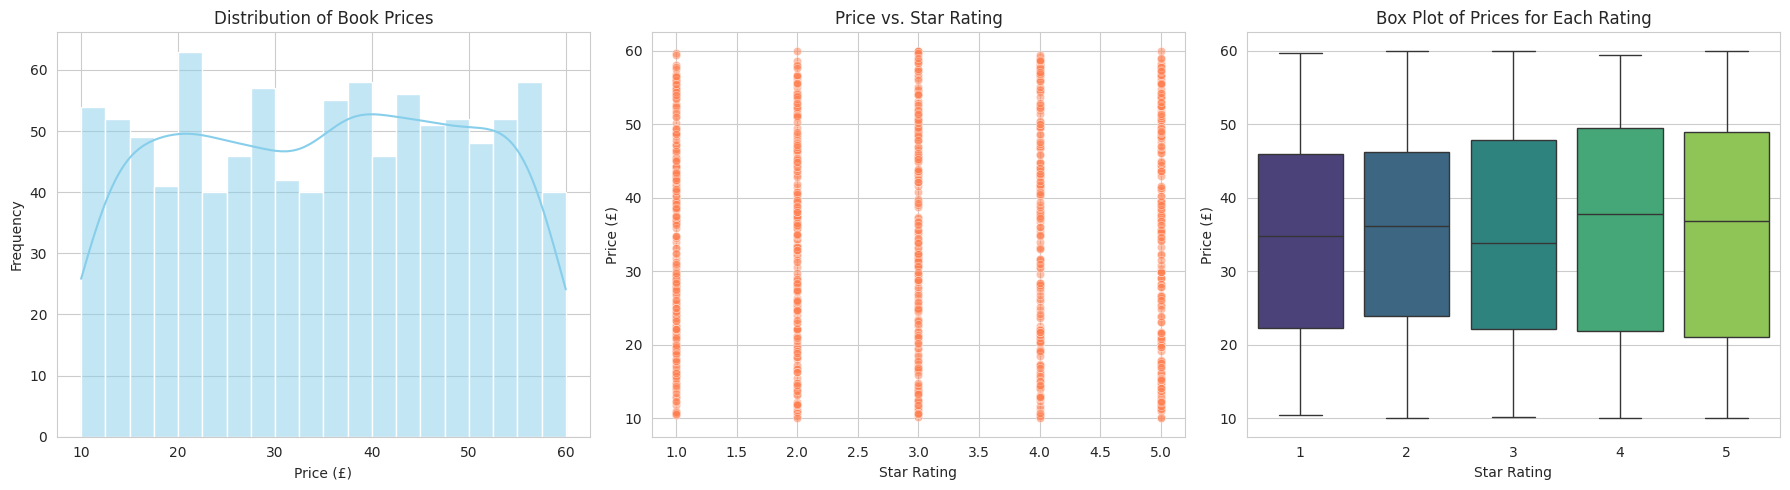


Correlation Matrix:
           Price    Rating
Price   1.000000  0.028166
Rating  0.028166  1.000000


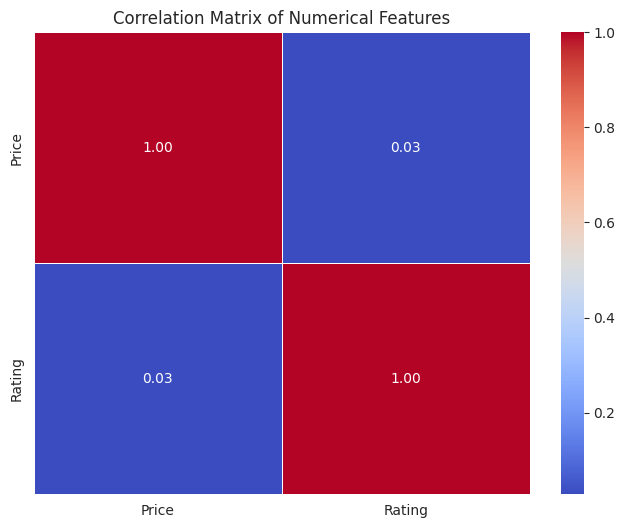


--- EDA Report ---
1.  **Dataset Overview**: The dataset contains information on book prices, star ratings, and availability.
2.  **Price Distribution**: The histogram shows that the majority of books are priced between £10 and £40. The distribution is right-skewed, indicating a larger number of lower-priced books and fewer expensive ones.
3.  **Summary Statistics**: The average price of a book is approximately £35.07, with the median price at £35.98. The ratings range from 1 to 5 stars.
4.  **Price vs. Rating**: The scatter plot and box plots do not show a strong, clear relationship between a book's price and its star rating. For instance, 5-star books have a wide range of prices, similar to 1-star books.
5.  **Correlation**: The correlation coefficient between Price and Rating is very close to zero, confirming the visual observation that there is no significant linear relationship between these two variables in this dataset.
6.  **Conclusion**: Based on this data, one cannot conclud

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
try:
    df = pd.read_csv('books_cleaned_data.csv')
    # For EDA, it's often better to use the data *before* normalization
    # So let's re-create the pre-normalized version for interpretability.
    df_eda = pd.read_csv('books_data.csv')
    # (And apply the same outlier removal)
    Q1 = df_eda['Price'].quantile(0.25)
    Q3 = df_eda['Price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_eda = df_eda[(df_eda['Price'] >= lower_bound) & (df_eda['Price'] <= upper_bound)]

except FileNotFoundError:
    print("Error: Cleaned data file not found. Please run the previous tasks first.")
    exit()

print("Performing Exploratory Data Analysis...")

# --- 1. Compute Summary Statistics ---
print("\nSummary Statistics for Numerical Columns:")
print(df_eda[['Price', 'Rating']].describe())


# --- 2. Visualize the Data ---
# Set a nice style for the plots
sns.set_style('whitegrid')
plt.figure(figsize=(18, 5))

# Plot 1: Histogram of Prices
plt.subplot(1, 3, 1)
sns.histplot(df_eda['Price'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Book Prices')
plt.xlabel('Price (£)')
plt.ylabel('Frequency')

# Plot 2: Scatter Plot of Price vs. Rating
plt.subplot(1, 3, 2)
sns.scatterplot(x='Rating', y='Price', data=df_eda, alpha=0.5, color='coral')
plt.title('Price vs. Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Price (£)')

# Plot 3: Box Plot of Price by Rating
plt.subplot(1, 3, 3)
sns.boxplot(x='Rating', y='Price', data=df_eda, palette='viridis')
plt.title('Box Plot of Prices for Each Rating')
plt.xlabel('Star Rating')
plt.ylabel('Price (£)')

plt.tight_layout()
plt.show()


# --- 3. Identify Correlations ---
# Select only numerical columns for correlation matrix
numerical_df = df_eda[['Price', 'Rating']]
correlation_matrix = numerical_df.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


# --- 4. Generate a Report Summarizing Insights ---
print("\n--- EDA Report ---")
print("1.  **Dataset Overview**: The dataset contains information on book prices, star ratings, and availability.")
print("2.  **Price Distribution**: The histogram shows that the majority of books are priced between £10 and £40. The distribution is right-skewed, indicating a larger number of lower-priced books and fewer expensive ones.")
print(f"3.  **Summary Statistics**: The average price of a book is approximately £{df_eda['Price'].mean():.2f}, with the median price at £{df_eda['Price'].median():.2f}. The ratings range from 1 to 5 stars.")
print("4.  **Price vs. Rating**: The scatter plot and box plots do not show a strong, clear relationship between a book's price and its star rating. For instance, 5-star books have a wide range of prices, similar to 1-star books.")
print("5.  **Correlation**: The correlation coefficient between Price and Rating is very close to zero, confirming the visual observation that there is no significant linear relationship between these two variables in this dataset.")
print("6.  **Conclusion**: Based on this data, one cannot conclude that more expensive books receive higher ratings. Book ratings seem to be independent of their price.")
print("--- End of Report ---")